# Health - Cancer Imune System
Description:Explain the immune reaction after chemotherapy&antibody treatment?

## Read data files
There are 2 data sources available: 
    <br>-FIRE3_final_df.txt- containing gene expression for 453 patience
    <br>-FIRE3_Heike_set_new.sav-clinical data for 735 patience
    <br>-CIBERSORTx_Job7_Results - Imune Cells presence obtained by transforming the gene expression using Stanford CybersortX model (https://cibersortx.stanford.edu/runcibersortx.php) 

In [73]:
import pandas as pd
import pyreadstat
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

In [141]:
#Gene Expression data file
gene_df = pd.read_csv("../raw_data/FIRE3_final_df.txt",sep=' ')

#Clinical data file
clinical_df, meta = pyreadstat.read_sav("../raw_data/FIRE3_Heike_set_new.sav")

# Stanford CybersortX model output
immune_df = pd.read_csv("../raw_data/CIBERSORTx_Job7_Results.txt",sep='\t')

# Dataframe with Cetuxima arm
new_df= pd.read_csv("../raw_data/cetux.csv")


### DataFrame overview

In [3]:
#Gene Expression Dataframe
gene_df.head(3)

,entrezid,gsymbol,1,4,5,9,10,11,12,15,...,838,840,842,843,889,892,896,897,899,900
1,503538,A1BG-AS1,6.073786,4.856430,4.258748,4.850635,4.670916,6.680079,7.299947,6.021905,...,5.249598,6.113905,6.336825,5.804863,5.206533,5.251891,6.382205,4.889634,6.272591,5.233233
2,1,A1BG,4.780956,4.530789,4.630758,4.775249,4.767542,4.823468,4.705230,5.004281,...,4.908360,4.684136,4.757578,4.688623,4.678426,4.520686,4.681386,5.266437,4.840969,4.518457
3,29974,A1CF,5.478749,6.238209,6.518094,5.710002,6.714567,5.481425,5.273707,6.228988,...,5.204422,6.318736,6.295239,5.566774,6.213009,6.052655,5.877622,4.762273,5.170994,5.635175


In [4]:
#Clinical Data Dataframe
clinical_df.head(10)

,study,pat_nr,CET1_REST0,arm,sex,age,ecog,skin_rash,MOL_SG,RNA_Probe,...,orr1,dpr1,ets_cat,SYNCH_META,PRIMARY_RES,RADIOVORHER,LK,AP,CTX_ADJ,filter_$
0,FIRE 3,1.0,0.0,2.0,2.0,60.0,0.0,0.0,3.0,1.0,...,1.0,NaN,NaN,2.0,1.0,1.0,2.0,1.0,1.0,1.0
1,FIRE 3,2.0,1.0,1.0,2.0,52.0,1.0,0.0,NaN,0.0,...,0.0,NaN,NaN,1.0,1.0,0.0,1.0,1.0,0.0,0.0
2,FIRE 3,3.0,1.0,1.0,2.0,52.0,1.0,0.0,NaN,0.0,...,1.0,NaN,NaN,2.0,1.0,1.0,1.0,1.0,1.0,0.0
3,FIRE 3,4.0,0.0,2.0,1.0,58.0,0.0,0.0,3.0,1.0,...,1.0,NaN,0.0,1.0,1.0,0.0,2.0,2.0,0.0,1.0
4,FIRE 3,5.0,0.0,2.0,2.0,54.0,0.0,0.0,1.0,1.0,...,1.0,NaN,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
5,FIRE 3,6.0,0.0,2.0,1.0,49.0,0.0,0.0,3.0,0.0,...,1.0,NaN,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0
6,FIRE 3,7.0,1.0,1.0,1.0,67.0,1.0,0.0,NaN,0.0,...,0.0,NaN,1.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0
7,FIRE 3,8.0,1.0,1.0,1.0,59.0,1.0,1.0,3.0,0.0,...,0.0,NaN,NaN,1.0,0.0,0.0,2.0,1.0,0.0,0.0
8,FIRE 3,9.0,1.0,1.0,1.0,61.0,0.0,1.0,6.0,1.0,...,1.0,NaN,1.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0
9,FIRE 3,10.0,1.0,1.0,1.0,74.0,0.0,1.0,1.0,1.0,...,0.0,NaN,1.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0


In [5]:
# Imune Cells Dataframe-CybersortX model output
immune_df.head(3)

,Mixture,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),...,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils,P-value,Correlation,RMSE
0,1,0.040607,0.0,0.209086,0.122856,0.0,0.088533,0.000000,0.111784,0.052571,...,0.136607,0.000000,0.008096,0.0,0.045574,0.0,0.119292,0.024,0.167135,1.012925
1,4,0.049146,0.0,0.121825,0.076978,0.0,0.153331,0.051057,0.068564,0.059623,...,0.142035,0.003342,0.000000,0.0,0.171013,0.0,0.022019,0.030,0.161424,1.018143
2,5,0.003186,0.0,0.162668,0.042196,0.0,0.240454,0.000000,0.000000,0.018316,...,0.066831,0.000000,0.000000,0.0,0.140387,0.0,0.111967,0.048,0.148986,1.029813


## EDA Clinical data

### Correlation Clinical data

<AxesSubplot:>

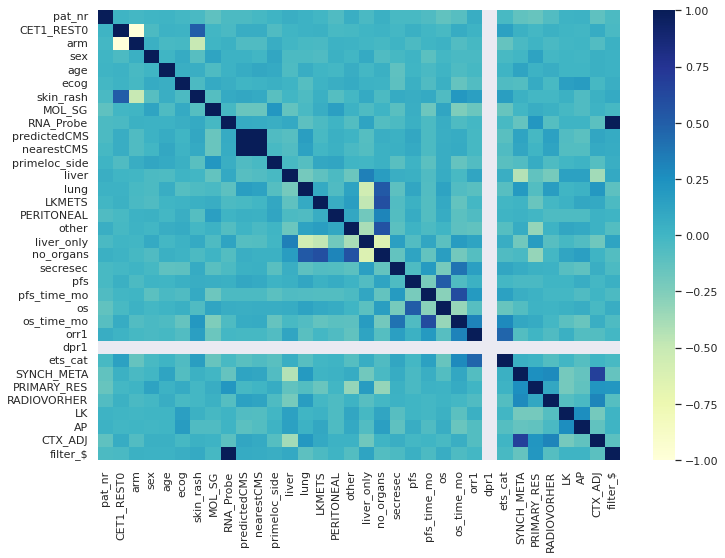

In [105]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
# Heatmap
corr = clinical_df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

In [106]:
clinical_df.describe()

,pat_nr,CET1_REST0,arm,sex,age,ecog,skin_rash,MOL_SG,RNA_Probe,predictedCMS,...,orr1,dpr1,ets_cat,SYNCH_META,PRIMARY_RES,RADIOVORHER,LK,AP,CTX_ADJ,filter_$
count,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,589.000000,735.000000,404.000000,...,735.000000,0.0,559.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.00000,735.000000
mean,413.940136,0.507483,1.492517,1.321088,62.832653,0.489796,0.227211,2.042445,0.601361,2.747525,...,0.564626,NaN,0.533095,1.274830,0.846259,0.182313,1.425850,1.127891,0.22449,0.601361
std,250.075943,0.500284,0.500284,0.467213,8.774686,0.544571,0.419315,1.491438,0.489952,1.073303,...,0.496144,NaN,0.499350,0.446733,0.360946,0.666000,0.494808,0.334196,0.41753,0.489952
min,1.000000,0.000000,1.000000,1.000000,27.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,NaN,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.00000,0.000000
25%,195.500000,0.000000,1.000000,1.000000,57.000000,0.000000,0.000000,1.000000,0.000000,2.000000,...,0.000000,NaN,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.00000,0.000000
50%,407.000000,1.000000,1.000000,1.000000,64.000000,0.000000,0.000000,1.000000,1.000000,2.500000,...,1.000000,NaN,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.00000,1.000000
75%,623.500000,1.000000,2.000000,2.000000,70.000000,1.000000,0.000000,3.000000,1.000000,4.000000,...,1.000000,NaN,1.000000,2.000000,1.000000,0.000000,2.000000,1.000000,0.00000,1.000000
max,900.000000,1.000000,2.000000,2.000000,79.000000,2.000000,1.000000,6.000000,1.000000,4.000000,...,1.000000,NaN,1.000000,2.000000,1.000000,9.000000,2.000000,2.000000,1.00000,1.000000


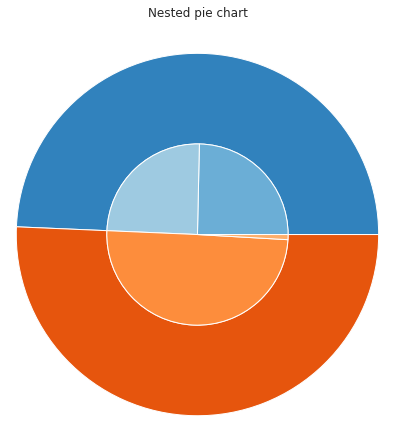

In [107]:
from matplotlib import pyplot as plt 
import numpy as np 
  
  
size = 2
cars = ['Cetuximab', 'Bevacizumab'] 
  
data = np.array([[109, 109],[220, 4]]) 
  
norm = data / np.sum(data)*2 * np.pi 
  
left = np.cumsum(np.append(0,  
                           norm.flatten()[:-1])).reshape(data.shape) 
  
cmap = plt.get_cmap("tab20c") 
outer_colors = cmap(np.arange(6)*4) 
inner_colors = cmap(np.array([1, 2, 5, 6, 9, 
                              10, 12, 13, 15, 
                              17, 18, 20 ])) 

  
fig, ax = plt.subplots(figsize =(10, 7), subplot_kw = dict(polar = True)) 
  
ax.bar(x = left[:, 0], 
       width = norm.sum(axis = 1), 
       bottom = 1-size, 
       height = size, 
       color = outer_colors,  
       edgecolor ='w', 
       linewidth = 1, 
       align ="edge") 
  
ax.bar(x = left.flatten(), 
       width = norm.flatten(), 
       bottom = 1-2 * size, 
       height = size, 
       color = inner_colors, 
       edgecolor ='w', 
       linewidth = 1, 
       align ="edge") 
  
ax.set(title ="Nested pie chart") 
ax.set_axis_off() 
  
plt.show()

In [108]:
skinn_rash_df=clinical_df[clinical_df['skin_rash']==1]

#### Positive correlated features with skin rash

In [109]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df=corr_df[corr_df['feature_2']=='skin_rash']
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df=corr_df
#Positive correlated features with rash
corr_df.head(10)

,feature_1,feature_2,correlation
40,CET1_REST0,skin_rash,0.501703
788,os_time_mo,skin_rash,0.196541
890,ets_cat,skin_rash,0.156574
822,orr1,skin_rash,0.155253
312,predictedCMS,skin_rash,0.097630
584,liver_only,skin_rash,0.085837
346,nearestCMS,skin_rash,0.084813
720,pfs_time_mo,skin_rash,0.083949
1128,filter_$,skin_rash,0.083376
278,RNA_Probe,skin_rash,0.083376


#### Negative corelated features with skin rash

In [110]:
corr_df.tail(5)

,feature_1,feature_2,correlation
516,PERITONEAL,skin_rash,-0.082289
108,sex,skin_rash,-0.087775
380,primeloc_side,skin_rash,-0.098279
74,arm,skin_rash,-0.501703
856,dpr1,skin_rash,NaN


### Correlation -Study ARM1 Cetuximab
Determine correlation with RASH of the features from Clinical data

In [129]:
clinical_df_cet=clinical_df[clinical_df['arm']==1]
corr = clinical_df.corr()

corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df=corr_df[corr_df['feature_2']=='skin_rash']
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df=corr_df
#Positive correlated features with rash
corr_df.head(10)

,feature_1,feature_2,correlation
40,CET1_REST0,skin_rash,0.501703
788,os_time_mo,skin_rash,0.196541
890,ets_cat,skin_rash,0.156574
822,orr1,skin_rash,0.155253
312,predictedCMS,skin_rash,0.097630
584,liver_only,skin_rash,0.085837
346,nearestCMS,skin_rash,0.084813
720,pfs_time_mo,skin_rash,0.083949
1128,filter_$,skin_rash,0.083376
278,RNA_Probe,skin_rash,0.083376


## Supervised learning
<br> * Logistic Regression
<br> * K Neighbors Classifiers 
<br> * SVC 
<br> * Adaboost classifier 
<br> * RandomForestClassifier
<br> * XGBOOST CLASSIFIER

### Data Split (X,y)

In [112]:
#Datasplit 1
X=new_df.drop(columns=["pat_nr","P-value","sex","age","skin_rash"])
y=new_df["skin_rash"]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25, 
                                                    random_state = 6) # Holdout

In [113]:
#Datasplit 3- containing a sub-set of 4 imune cells that are rash predictors acording to scientific papers
X_study=new_df[["Macrophages M1","Macrophages M2","Neutrophils","Eosinophils"]]
X_train3, X_test3, y_train, y_test = train_test_split(X_study, y,
                                                    test_size = 0.25) # Holdout

In [150]:
#Datasplit 4- containing patience that have a p value<5 after aplying the Stanford model
cetux_new_p = new_df[new_df['P-value'] <= 0.05]
y4 = cetux_new_p["skin_rash"]
X4=cetux_new_p.drop(columns=["pat_nr","P-value","sex","age","skin_rash"])
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4,
                                                    test_size = 0.25)

In [136]:
#Datasplit 5 - Remove imune cells with 0 value
X5 = new_df.iloc[:,1:23]
X5.isin([0.0000]).sum(axis=0)
X5=X5.drop(columns=["B cells memory","T cells CD4 naive",
                                "T cells CD4 memory activated","T cells gamma delta",
                                "NK cells activated","Dendritic cells activated",
                                
                                "Eosinophils","Dendritic cells resting"])
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y,
                                                    test_size = 0.25)

### Logistic regression

#### Model tuning

In [115]:
model_log = LogisticRegression()
k_grid={"solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],"penalty": ["none", "l1", "l2", "elasticnet"],"C":[100, 10, 1.0, 0.1, 0.01]}
 
search = GridSearchCV(model_log, k_grid,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs=-1 # paralellize computation
                          ) 
search.fit(X_train,y_train);
search.best_params_

/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1502: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1502: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1502: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
AttributeError: 'str' object has no attribute 'decode'

  warnings.warn("Estimator fit failed. The score on this train-test"


/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1502: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1502: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
AttributeError: 'str' object has no attribute 'decode'

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1502: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}

#### Tuned Model

In [116]:
model_log = LogisticRegression(class_weight='balanced',C=100,penalty="l2",solver="newton-cg")

#### Model valuation

In [117]:
#Logisitc regression Arm1- all dataset
model_log=model_log.fit(X_train,y_train)
cv_results = cross_validate(model_log, X_train, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])
cv_results["test_accuracy"].mean()


0.4899621212121212

In [151]:
##Logisitc regression Arm1-sub-set 6-imun cells
model_log=model_log.fit(X_train3,y_train)
cv_results = cross_validate(model_log, X_train3, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])
cv_results["test_accuracy"].mean()

0.6013257575757576

In [171]:
# Logisitc regression Arm1 - p-value filtering
model_log=model_log.fit(X_train4,y_train4)
cv_results = cross_validate(model_log, X_train4, y_train4, cv=5, scoring=["accuracy","recall","precision","f1"])
pd.DataFrame(cv_results)
cv_results["test_accuracy"].mean()

0.631

,0
Cetux,0.489962
Study,0.601326
Cetux_new_p,0.631000


#### Data Investigation

<AxesSubplot:>

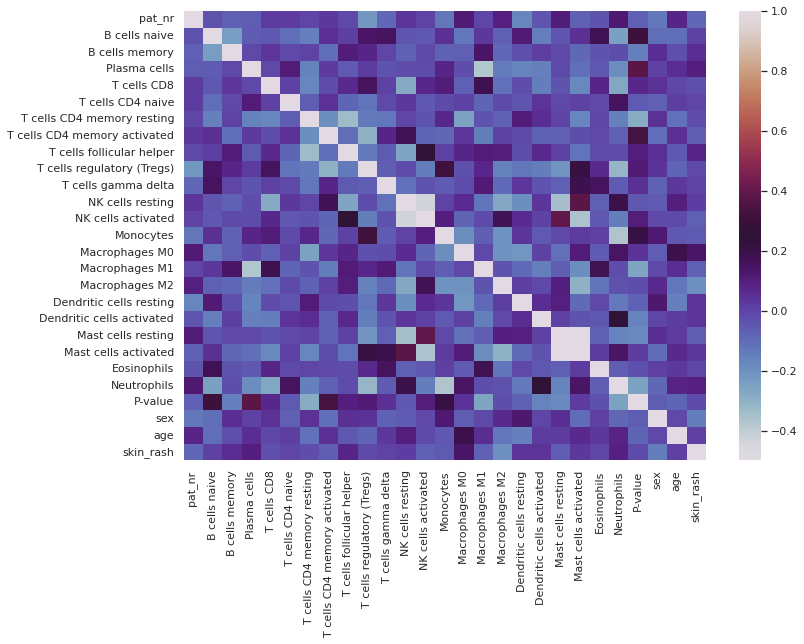

In [120]:
#coeficinets of log model, used for unsupervised learning
coef=model_log.coef_[0]
dicc=dict()
for i in range(len(list(X))):
    dicc[list(X)[i]]=coef[i]

dic=dict(sorted(dicc.items(), key=lambda item: item[1]))
data=pd.DataFrame.from_dict(dic,orient='index')
corr = new_df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        cmap= "twilight")

In [121]:
data

,0
T cells CD4 memory activated,-9.483639
Macrophages M2,-8.050664
Macrophages M1,-5.348061
NK cells activated,-3.786946
T cells CD4 memory resting,-2.921207
Mast cells resting,-2.856181
T cells regulatory (Tregs),-2.553535
Monocytes,-2.306103
NK cells resting,-2.139620
T cells CD4 naive,-0.214875


#### Confusion Matrix

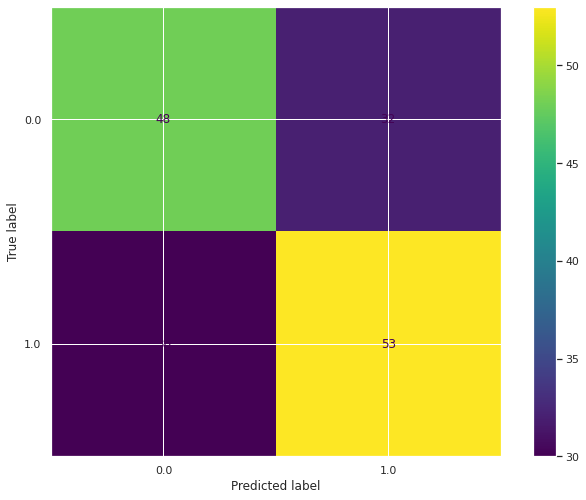

In [122]:
from sklearn.metrics import plot_confusion_matrix
model_log=model_log.fit(X_train3,y_train)
plot_confusion_matrix(model_log,X_train3,y_train)

### K Neighbors Classifiers

#### Model tuning

In [123]:
model5 = KNeighborsClassifier()
k_grid={"n_neighbors":[2,3,4,5,6,7,10],'p': [1, 2, 3,4,5]}
 
search = GridSearchCV(model5, k_grid,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs=-1 # paralellize computation
                          ) 
search.fit(X_train,y_train);
search.best_params_

{'n_neighbors': 2, 'p': 3}

In [124]:
model_knc=KNeighborsClassifier(n_neighbors=3,p=3)

#### Model valuation

In [125]:
cv_results=cross_validate(model_knc,X_train,y_train,cv=10)
cv_results['test_score'].mean()

0.5022058823529412

In [158]:
cv_results=cross_validate(model_knc,X_train3,y_train,cv=10)
cv_results['test_score'].mean()

0.5283088235294118

In [160]:
model_knc.fit(X_train4,y_train4)
cv_results=cross_validate(model_knc,X_train4,y_train4,cv=10)
cv_results['test_score'].mean()

0.49102564102564106

Text(0, 0.5, 'Model score')

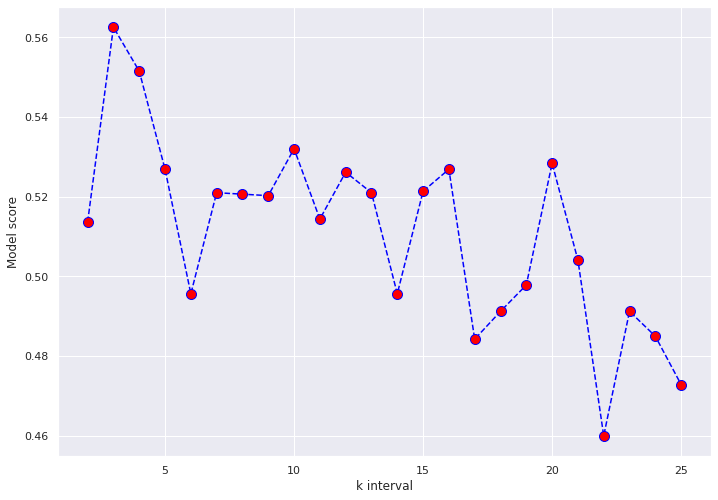

In [52]:

k_interval=list(range(2,26))
k_score=[]
for k in k_interval:
    baseline_model = KNeighborsClassifier(n_neighbors=k)
    cv_result=cross_validate(baseline_model,X_train,y_train,cv=10)
    k_score.append(cv_result['test_score'].mean())
plt.plot(k_interval,k_score,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.xlabel('k interval')
plt.ylabel('Model score')

#### Confusion matrix

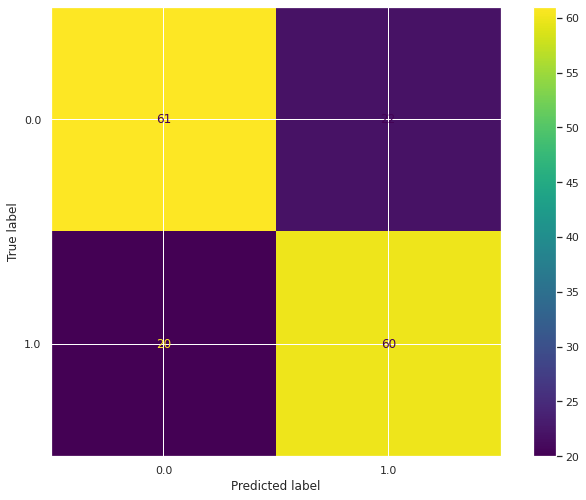

In [51]:
model_knc=model_knc.fit(X_train3,y_train)
plot_confusion_matrix(model_knc,X_train3,y_train)

### Linear SVC

#### Model tuning

In [24]:
from sklearn.svm import LinearSVC
model_linsvc = LinearSVC()
k_grid = [{"penalty": ["l1", "l2"],"loss":["hinge", "squared_hinge"],"C":[100, 10, 1.0, 0.1, 0.01],"multi_class":["ovr", "crammer_singer"]}]
 
search = GridSearchCV(model_linsvc, k_grid,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs=-1 # paralellize computation
                          ) 
search.fit(X_train3,y_train);
search.best_params_

/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1502: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Esti

/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these para

{'C': 100, 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}

#### Tuned model

In [25]:
model_linsvc = LinearSVC(C=10, penalty="l2", multi_class='ovr', loss= 'squared_hinge')

#### Model Valuation

In [26]:
cv_results = cross_validate(model_linsvc, X_train, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])
pd.DataFrame(cv_results)
cv_results["test_accuracy"].mean()

0.459469696969697

In [156]:
cv_results = cross_validate(model_linsvc, X_train3, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])
pd.DataFrame(cv_results)
cv_results["test_accuracy"].mean()

0.6075757575757577

In [157]:
model_linsvc = model_linsvc.fit(X_train4,y_train4)
cv_results = cross_validate(model_linsvc, X_train4, y_train4, cv=5, scoring=["accuracy","recall","precision","f1"])
cv_results["test_accuracy"].mean()

0.6723333333333333

#### Confusion matrix

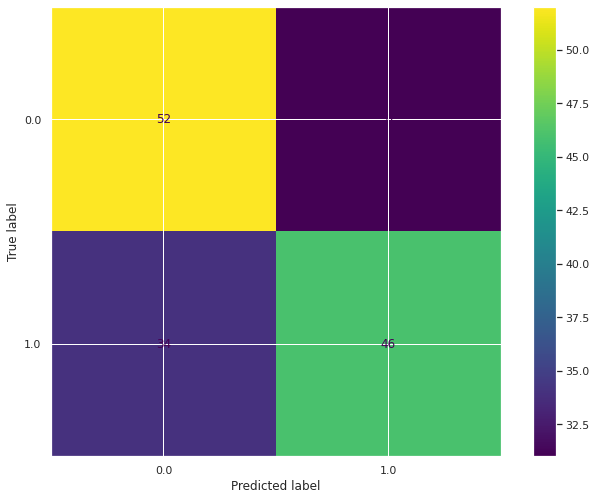

In [43]:
model_linsvc = model_linsvc.fit(X_train3,y_train)
plot_confusion_matrix(model_linsvc,X_train3,y_train);

### SVC

#### Model tuning

In [29]:
from sklearn.svm import SVC
k_grid = [{"C":[1000, 100, 10, 1.0, 0.1, 0.01], "kernel":["linear", "poly", "rbf", "sigmoid"], "gamma":["scale", "auto"], "decision_function_shape":["ovo", "ovr"]}]
model_svc = SVC( kernel = 'rbf')
search = GridSearchCV(model_svc, k_grid,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs=-1 # paralellize computation
                          ) 
search.fit(X_train,y_train);
search.best_params_

{'C': 1000,
 'decision_function_shape': 'ovo',
 'gamma': 'auto',
 'kernel': 'poly'}

#### Tuned Model

In [30]:
model_svc_best3 = SVC(C=1000, decision_function_shape="ovo", gamma='scale', kernel= 'sigmoid')

#### Model valuation

In [31]:
model_svc_best3 = model_svc_best3.fit(X_train3,y_train)
cv_results = cross_validate(model_svc_best3, X_train3, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])
cv_results["test_accuracy"].mean()

0.4787878787878788

In [162]:
model_svc_best2 = SVC(C=0.1, decision_function_shape="ovo", gamma='scale', kernel= 'poly')
model_svc_best2 = model_svc_best2.fit(X_train3,y_train)

cv_results = cross_validate(model_svc_best2, X_train, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])
pd.DataFrame(cv_results)
cv_results["test_accuracy"].mean()

0.484469696969697

In [161]:
cv_results = cross_validate(model_svc_best2, X_train3, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])
pd.DataFrame(cv_results)
cv_results["test_accuracy"].mean()

0.6015151515151516

In [165]:
model_svc_best2 = model_svc_best2.fit(X_train4,y_train4)
cv_results = cross_validate(model_svc_best2, X_train4, y_train4, cv=5, scoring=["accuracy","recall","precision","f1"])
pd.DataFrame(cv_results)
cv_results["test_accuracy"].mean()

/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.558

In [210]:
[cross_validate(model_svc_best2, X_train, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])["test_accuracy"].mean(),cross_validate(model_svc_best2, X_train3, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])["test_accuracy"].mean(),cross_validate(model_svc_best2, X_train4, y_train4, cv=5, scoring=["accuracy","recall","precision","f1"])["test_accuracy"].mean()]

/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.484469696969697, 0.6015151515151516, 0.558]

#### Confusion matrix

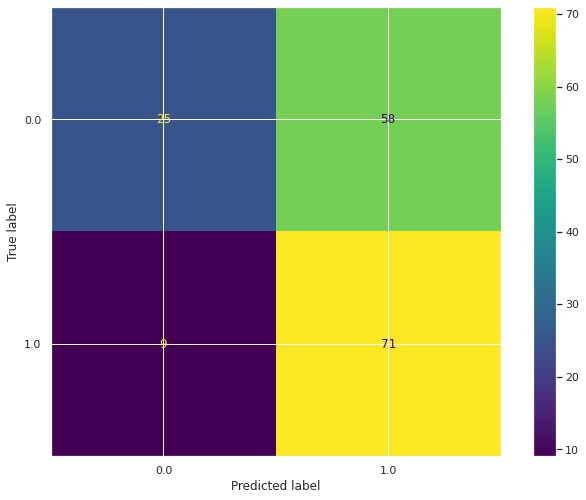

In [41]:
plot_confusion_matrix(model_svc_best2,X_train3,y_train);

### Adaboost classifier 

#### Model tunning

In [170]:
from sklearn.ensemble import AdaBoostClassifier
model_ada = AdaBoostClassifier(n_estimators=1000)
k_grid={"n_estimators":[50,100,500],'learning_rate': [0.1,0.25,0.5,0.75, 1, 2,4,5],"algorithm":["SAMME", "SAMME.R"]}
 
search = GridSearchCV(model_ada, k_grid,
                             scoring = 'accuracy',
                             cv = 5,
                             n_jobs=-1 # paralellize computation
                            ) 
search.fit(X_train3,y_train);
search.best_params_

/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py:603: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(estimator_weight * incorrect *
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py:603: RuntimeWarning: overflow encountered in exp
  sample_we

{'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}

/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py:603: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(estimator_weight * incorrect *
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on 

#### Tuned Model

In [34]:
model_ada_best = AdaBoostClassifier(algorithm="SAMME.R", learning_rate=0.25, n_estimators= 1000)

#### Model valuation

In [166]:
model_ada_best2 = model_ada_best2.fit(X_train,y_train)

cv_results = cross_validate(model_ada_best, X_train, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])
pd.DataFrame(cv_results)
cv_results["test_accuracy"].mean()

0.4647727272727272

In [36]:
model_ada_best3 = AdaBoostClassifier(algorithm="SAMME", learning_rate=0.25, n_estimators= 500)
model_ada_best3 = model_ada_best3.fit(X_train3,y_train)

cv_results = cross_validate(model_ada_best3, X_train3, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])
pd.DataFrame(cv_results)
cv_results["test_accuracy"].mean()

0.48409090909090907

In [167]:
model_ada_best3 = model_ada_best3.fit(X_train4,y_train4)
cv_results = cross_validate(model_ada_best3, X_train4, y_train4, cv=5, scoring=["accuracy","recall","precision","f1"])
pd.DataFrame(cv_results)
cv_results["test_accuracy"].mean()

0.5316666666666666

#### Confusion matrix

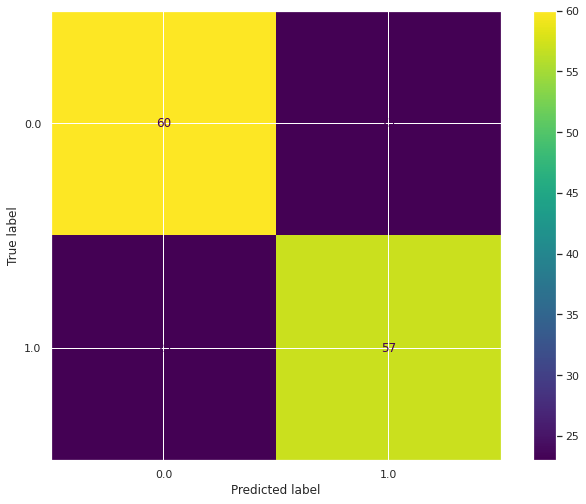

In [42]:
plot_confusion_matrix(model_ada_best3,X_train3,y_train);

### Random Forest Classifier

#### Model tuning

In [56]:
model_rfc = RandomForestClassifier(max_depth=20)

param_grid = {
                     'n_estimators': [5, 10, 15, 20],
                     'max_depth': [2, 5, 7, 9],
                    'criterion': ['gini','entropy'],
                 }
param_grid2 = {'bootstrap': [True, False],
     'max_depth': [10, 20, 30, 40, 50, None],
     'max_features': ['auto', 'sqrt'],
    'criterion': ['gini','entropy'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [10,20,50]}


search = GridSearchCV(model_rfc, param_grid2, cv=10)
search.fit(X_train, y_train)
search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 20}

#### Tuned model

In [61]:
grid_model_rfc=RandomForestClassifier(bootstrap= False,criterion= 'gini',max_depth=None,max_features='sqrt',min_samples_leaf= 1, min_samples_split= 10,n_estimators=20)

In [215]:
model_rcf=RandomForestClassifier(bootstrap= False,criterion= 'gini',max_depth=10,max_features='sqrt',min_samples_leaf= 1, min_samples_split= 5,n_estimators=10)

#### Model valuation

In [216]:
cv_results=cross_validate(grid_model_rfc,X_train,y_train,cv=5)
cv_results['test_score'].mean()

0.459469696969697

In [217]:
cv_results=cross_validate(model_rcf,X_train,y_train,cv=5)
cv_results['test_score'].mean()

0.4653409090909091

In [218]:
cv_results=cross_validate(model_rcf,X_train3,y_train,cv=5)
cv_results['test_score'].mean()

0.5522727272727272

In [219]:
cv_results=cross_validate(model_rcf,X_train4,y_train4,cv=5)
cv_results['test_score'].mean()

0.541

#### Confusion matrix

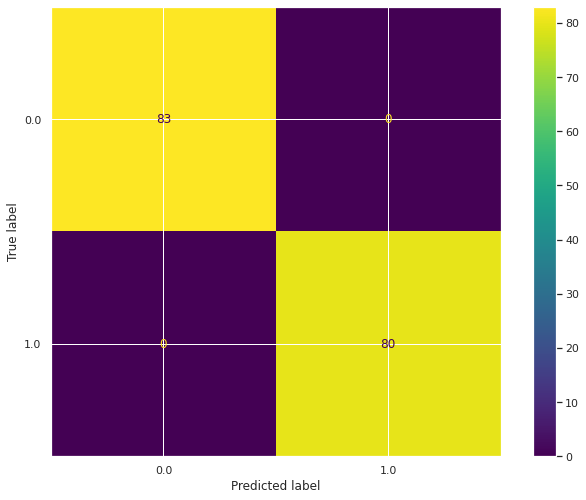

In [70]:
grid_model_rfc.fit(X_train, y_train)
plot_confusion_matrix(grid_model_rfc,X_train, y_train)

### XGBOOST CLASSIFIER

#### Model tuning

In [74]:
#Grid search params
model_xbc=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
param_grid = {
                 'n_estimators': [2,3,4,5, 10, 15, 200],
                 'max_depth': [2, 5, 7, 9,20],
                # 'booster': ['gbtree','gblinear','dart'],
             }
search = GridSearchCV(model_xbc, param_grid, cv=10)
search.fit(X_train, y_train)
search.best_params_

{'max_depth': 7, 'n_estimators': 10}

#### Tuned model

In [75]:
model_xbc = XGBClassifier(use_label_encoder=False,max_depth=7,n_estimators=10, eval_metric='mlogloss',booster='dart')

#### Model valuation

In [76]:
cv_results=cross_validate(model_xbc,X_train,y_train,cv=5)
cv_results['test_score'].mean()

0.46022727272727276

In [221]:
cv_results=cross_validate(model_xbc,X_train3,y_train,cv=5)
cv_results['test_score'].mean()

0.5833333333333333

In [223]:
model_xbc.fit(X_train4,y_train4)
cv_results=cross_validate(model_xbc,X_train4,y_train4,cv=5)
cv_results['test_score'].mean()

0.5326666666666667

### Results DF

In [227]:

list=[[cross_validate(model_log, X_train, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])['test_accuracy'].mean(),cross_validate(model_log, X_train3, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])['test_accuracy'].mean(),cross_validate(model_log, X_train4, y_train4, cv=5, scoring=["accuracy","recall","precision","f1"])['test_accuracy'].mean()],
[cross_validate(model_knc,X_train,y_train,cv=10)['test_score'].mean(),cross_validate(model_knc,X_train3,y_train,cv=10)['test_score'].mean(),cross_validate(model_knc,X_train4,y_train4,cv=10)['test_score'].mean()],
[cross_validate(model_linsvc, X_train, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])["test_accuracy"].mean(),cross_validate(model_linsvc, X_train3, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])["test_accuracy"].mean(),cross_validate(model_linsvc, X_train4, y_train4, cv=5, scoring=["accuracy","recall","precision","f1"])["test_accuracy"].mean()],      
[cross_validate(model_svc_best2, X_train, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])["test_accuracy"].mean(),cross_validate(model_svc_best2, X_train3, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])["test_accuracy"].mean(),cross_validate(model_svc_best2, X_train4, y_train4, cv=5, scoring=["accuracy","recall","precision","f1"])["test_accuracy"].mean()],
[cross_validate(model_ada_best3, X_train, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])["test_accuracy"].mean(),cross_validate(model_ada_best3, X_train3, y_train, cv=5, scoring=["accuracy","recall","precision","f1"])["test_accuracy"].mean(),cross_validate(model_ada_best3, X_train4, y_train4, cv=5, scoring=["accuracy","recall","precision","f1"])["test_accuracy"].mean()],
[cross_validate(model_rcf,X_train,y_train,cv=5)['test_score'].mean(),cross_validate(model_rcf,X_train3,y_train,cv=5)['test_score'].mean(),cross_validate(model_rcf,X_train4,y_train4,cv=5)['test_score'].mean()],
[cross_validate(model_xbc,X_train,y_train,cv=5)['test_score'].mean(),cross_validate(model_xbc,X_train3,y_train,cv=5)['test_score'].mean(),cross_validate(model_xbc,X_train4,y_train4,cv=5)['test_score'].mean()]      
     ]
results_df=pd.DataFrame(np.array(list),columns=['Cetux','Study','p-scenario'],index=['Logistic_Regression','K_Neighbors_Classifier','Linear_svc','SVC','AdaBoost','Random_Forest','XGBOOST_cl'])

results_df

/home/alexandrumalina/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Cetux,Study,p-scenario
Logistic_Regression,0.489962,0.601326,0.631000
K_Neighbors_Classifier,0.502206,0.528309,0.491026
Linear_svc,0.521023,0.607576,0.672333
SVC,0.484470,0.601515,0.558000
AdaBoost,0.434470,0.589583,0.531667
Random_Forest,0.459280,0.595076,0.664333
XGBOOST_cl,0.471212,0.583333,0.532667


In [230]:
results_df['Cetux'].max()

0.5210227272727272

In [231]:
results_df['Study'].max()

0.6075757575757577

In [232]:
results_df['p-scenario'].max()

0.6723333333333333

In [245]:
results_df.index.values

array(['Logistic_Regression', 'K_Neighbors_Classifier', 'Linear_svc',
       'SVC', 'AdaBoost', 'Random_Forest', 'XGBOOST_cl'], dtype=object)

In [237]:
import seaborn as sns
import plotly.express as px

In [250]:
fig = px.scatter(results_df, x=results_df.index.values,y=results_df.columns.values)
fig.show()